In [1]:
import tensorflow as tf

In [2]:
!pip install path-explain

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from path_explain import PathExplainerTF
from path_explain.utils import set_up_environment
from path_explain.plot.scatter import scatter_plot
from path_explain.plot.summary import summary_plot


from preprocess import diabetes_data

In [5]:
set_up_environment(visible_devices='3')
x_train, y_train, x_test, y_test, feature_names, x_train_un, x_test_un = diabetes_data()
total_df = pd.concat([x_train_un, x_test_un])

In [6]:
x_test

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
274,57,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
313,54,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0
247,53,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0
181,31,0,1,1,1,1,1,0,0,1,1,0,1,1,0,0
478,54,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,62,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0
233,50,1,0,0,0,1,0,0,0,1,0,1,1,1,1,0
8,67,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1
375,38,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,  activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.sigmoid))

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                               decay_steps=1,
                                                               decay_rate=0.99,
                                                               staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train, y_train, batch_size=242, epochs=200, verbose=0)
train_loss, train_accuracy, train_auc = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test, batch_size=51, verbose=0)


In [9]:
print('Train loss: {:.4f}\tTrain Accuracy: {:.4f}\tTrain AUC: {:.4f}'.format(train_loss, train_accuracy, train_auc))
print('Test loss: {:.4f}\tTest Accuracy: {:.4f}\tTest AUC: {:.4f}'.format(test_loss, test_accuracy, test_auc))

Train loss: 0.0678	Train Accuracy: 0.9832	Train AUC: 0.9977
Test loss: 0.0709	Test Accuracy: 0.9615	Test AUC: 0.9988


In [10]:
y_pred = model.predict(x_test)
y_pred_discrete = (y_pred > 0.5).astype(int)[:, 0]

tpr = np.sum(y_test[y_test == 1] == y_pred_discrete[y_test == 1]) / np.sum(y_test == 1)
tnr = np.sum(y_test[y_test == 0] == y_pred_discrete[y_test == 0]) / np.sum(y_test == 0)
print('True Positive Rate: {:.4f}\t True Negative Rate: {:.4f}'.format(tpr, tnr))

True Positive Rate: 0.9844	 True Negative Rate: 0.9250


In [11]:
explainer = PathExplainerTF(model)

In [12]:
all_data = np.concatenate([x_train, x_test], axis=0)

In [13]:
attributions = explainer.attributions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 520/520 [00:05<00:00, 103.50it/s]


In [14]:
interactions = explainer.interactions(inputs=all_data,
                                      baseline=x_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

  0%|          | 2/520 [00:02<09:16,  1.07s/it]

100%|██████████| 520/520 [08:45<00:00,  1.01s/it]


In [15]:
all_data_renorm = np.concatenate([x_train_un, x_test_un])

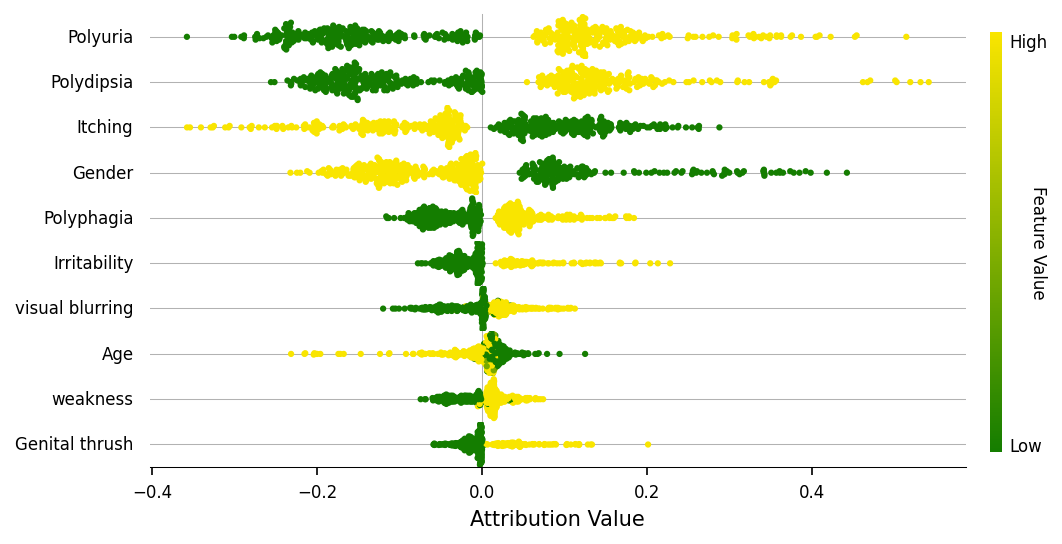

In [16]:
summary_plot(attributions,
             all_data_renorm,
             interactions=None,
             interaction_feature=None,
             feature_names=feature_names,
             plot_top_k=10)

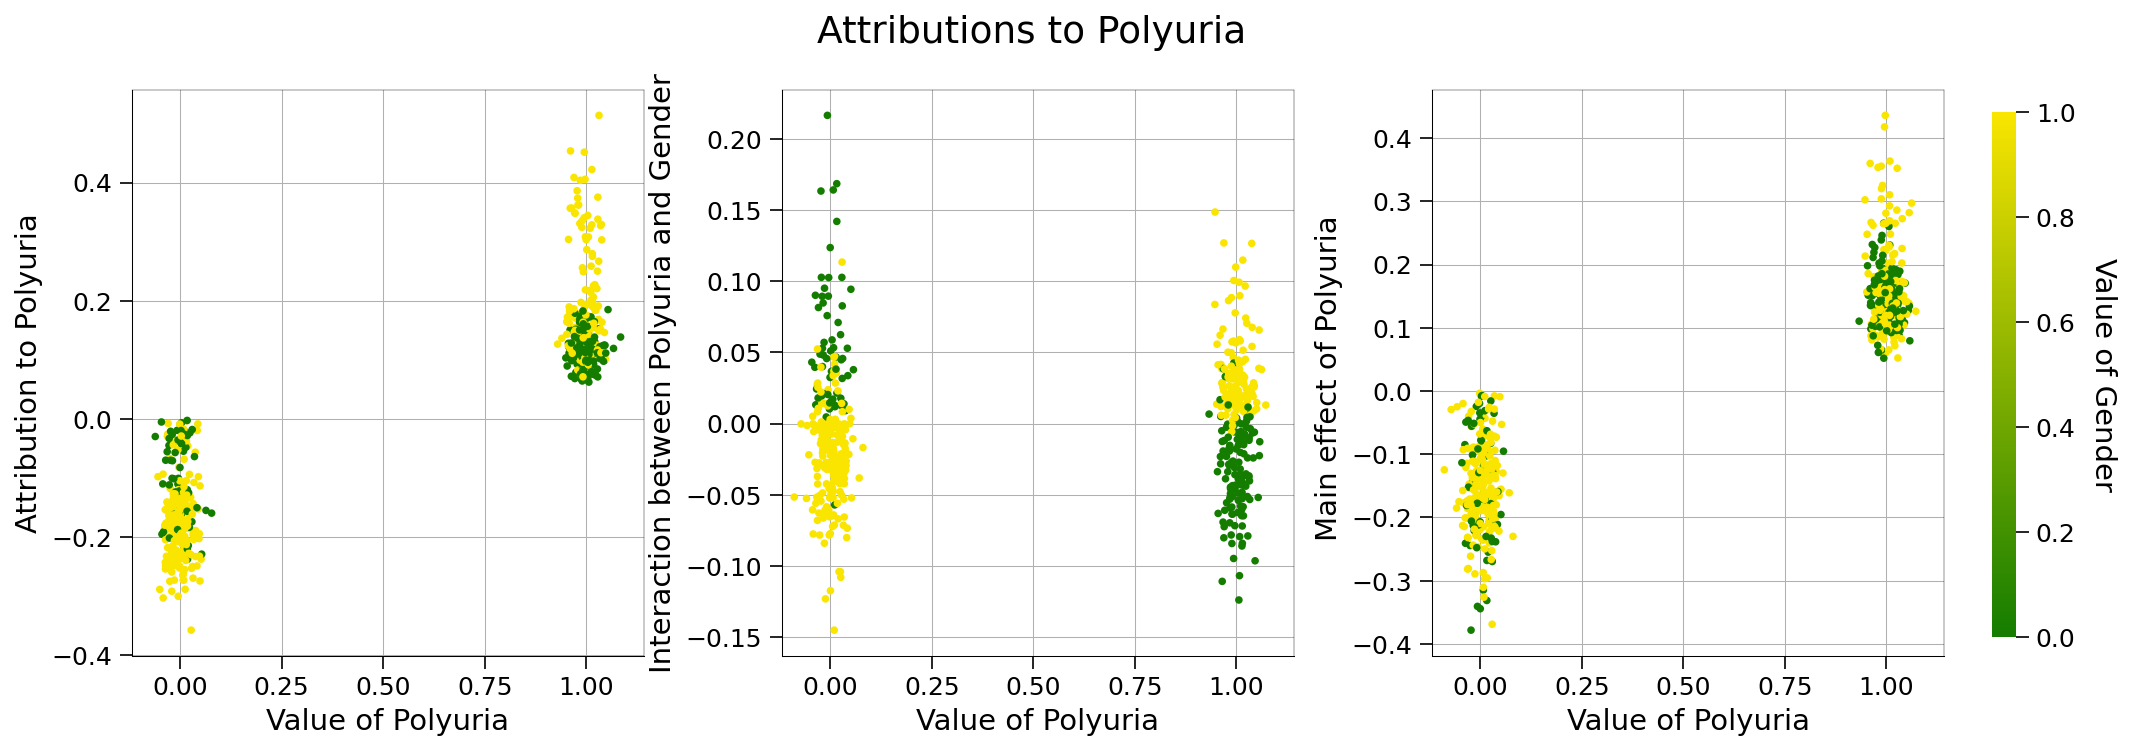

In [17]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='Polyuria',
                        interactions=interactions,
                        color_by='Gender',
                        feature_names=feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)

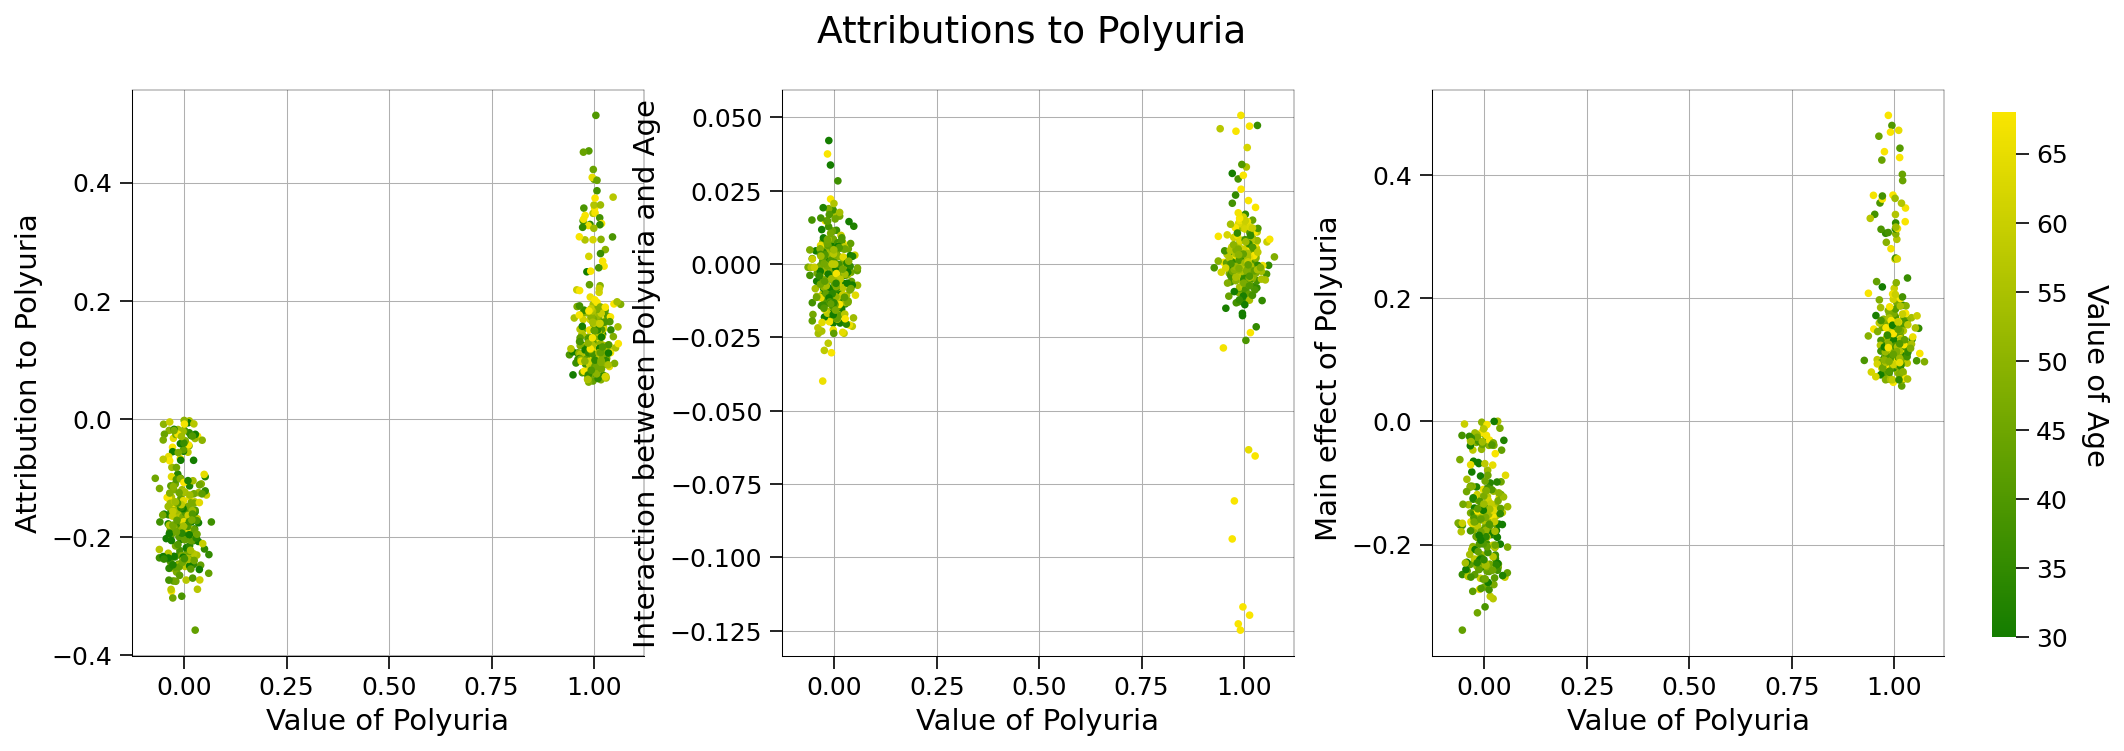

In [18]:
fig, axs = scatter_plot(attributions,
                        all_data_renorm,
                        feature_index='Polyuria',
                        interactions=interactions,
                        color_by='Age',
                        feature_names=feature_names,
                        scale_y_ind=True,
                        add_random_noise_x=True)